In [1]:
import fitsio
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib
from scipy import interpolate as inter
from astropy.table import Table
import BalrogTestConfig as balrConfig
import Config
from TrainAndFullMap import *
from timeit import default_timer as timer
matplotlib.style.use('des_dr1')

In [2]:
cutOffPercent = .01
perObjectsToUse = 0
res = 4096
binNum = 10

In [3]:
persToUse = np.logspace(0, 2, 20)

In [6]:
def mostSigInd(y):
    maxSquaredDiff = 0
    index = -1
    
    maxSingError = np.max(np.abs(y - 1))
    
    if maxSingError <= cutOffPercent:
        return index, maxSingError
    
    for i in range(len(y)):
        yi = y[i]
        
        diff = np.sum((yi - 1)**2)
        
        if diff > maxSquaredDiff:
            maxSquaredDiff = diff
            index = i
            
    return index, maxSingError

In [7]:
allPixFile = balrConfig.test1aAllPixFile
galaFile = balrConfig.test1aGalaFile
validPixFile = balrConfig.test1aValidPixFile
condFiles = balrConfig.test1aCondFiles

origCondMaps = []

# This loops over every condition file
for condFile in condFiles:
    condData = fitsio.read(condFile) # This reads in the data
    origCondMaps.append(condData['SIGNAL']) # Only stores the values that are in pixels with injections

origCondMaps = np.array(origCondMaps) # Converts to an array

origInjData = fitsio.read(allPixFile)

origInjPix = hp.ang2pix(res, origInjData['RA'], origInjData['DEC'], nest = True, lonlat = True)
origValidPix = np.unique(origInjPix)

# testSubset = np.full(len(origValidPix), False, dtype = bool)
# testSubset[0:int(0.2*len(testSubset))] = True
# np.random.shuffle(testSubset)
# testPixels = origValidPix[testSubset]

origDetData = fitsio.read(galaFile)

origDetPix = hp.ang2pix(res, origDetData['RA'], origDetData['DEC'], nest = True, lonlat = True)

origInjPix = np.sort(origInjPix)

origDetPix = np.sort(origDetPix)

# injTestInds = np.isin(origInjPix, testPixels)
# potentialInjTrainInds = ~injTestInds

# Everything from here until the main loop is to generate matchInds

origInjPixUnique, origInjPixCounts = np.unique(origInjPix, return_counts = True)

_, origAllDetPixCounts = np.unique(np.append(origDetPix, origValidPix), return_counts = True)
origAllDetPixCounts = origAllDetPixCounts - 1

matchInds = np.zeros(len(origDetPix), dtype = int)

startInjInds = np.append(np.array([0]), np.cumsum(origInjPixCounts)[:-1])

startDetInds = np.append(np.array([0]), np.cumsum(origAllDetPixCounts)[:-1])

for i in np.arange(len(origAllDetPixCounts)):
    if origAllDetPixCounts[i] == 0:
        continue
    matchInds[startDetInds[i]: startDetInds[i] + origAllDetPixCounts[i]] = np.arange(origAllDetPixCounts[i]).astype(int) + startInjInds[i]
    
for perObjectsToUse in persToUse:
    
    # perObjectsToUse += 1
    
    includeInds = np.full(len(origInjPix), False, dtype = bool)
    includeInds[0:int((float(perObjectsToUse)*len(includeInds)) / 100)] = True
    np.random.shuffle(includeInds)
    
#     includeInds = np.full(np.sum(potentialInjTrainInds), False, dtype = bool)
#     includeInds[0:int((float(perObjectsToUse)*len(includeInds)) / 100)] = True
#     np.random.shuffle(includeInds)
    
#     injTrainInds = np.copy(potentialInjTrainInds)
#     injTrainInds[np.where(injTrainInds)[0]] = includeInds
    
    detPix = origDetPix[includeInds[matchInds]]
    injPix = origInjPix[includeInds]
    
#     detPixTest = origDetPix[injTestInds[matchInds]]
#     injPixTest = origInjPix[injTestInds]
    
#     detPixTrain = origDetPix[injTrainInds[matchInds]]
#     injPixTrain = origInjPix[injTrainInds]
    
#     detPix = np.sort(np.append(detPixTest, detPixTrain))
#     injPix = np.sort(np.append(injPixTest, injPixTrain))

    validPix =  np.unique(injPix)
    
    condCrop = np.isin(origValidPix, validPix)
    
    constantTrainPixIndicator, origDetPixCounts = np.unique(np.append(validPix, detPix), return_counts = True)
    origDetPixCounts = origDetPixCounts - 1
    
    condMaps = []

    # This loops over every condition file
    for origCondMap in origCondMaps:
        condMaps.append(origCondMap[condCrop]) # Only stores the values that are in pixels with injections

    condMaps = np.array(condMaps)
    
    trainInds = np.full(len(condMaps[0]), False, dtype = bool)
    trainInds[0:int(0.8*len(trainInds))] = True
    np.random.shuffle(trainInds)
    
    # trainInds = np.isin(constantTrainPixIndicator, np.unique(injPixTrain))
    
    aveDetTrain = np.sum(origDetPixCounts[trainInds]) / len(origDetPixCounts[trainInds])

    sortInds = []
    for i in range(len(condMaps)):
        sortInds.append(condMaps[i][trainInds].argsort())
    sortInds = np.array(sortInds)
    
    binIndLims = [0]

    for j in range(binNum):
        binIndLims.append(int((np.sum(trainInds) - binIndLims[-1]) / (binNum - j)) + (binIndLims[-1]))
        
    xBins = []

    for i in range(len(condMaps)):
        cond_Map_Sort = condMaps[i][trainInds][sortInds[i][::1]]
        condBins = []
        for j in range(binNum):
            condBins.append(cond_Map_Sort[binIndLims[j]:binIndLims[j+1]])
        indXBin = []

        for j in range(binNum):
            indXBin.append(np.sum(condBins[j]) / len(condBins[j]))

        xBins.append(np.array(indXBin))

    xBins = np.array(xBins)
    
    yBinsOrig = []
    for i in range(len(condMaps)):
        detSort = origDetPixCounts[trainInds][sortInds[i][::1]]
        detBins = []
        for j in range(binNum):
            detBins.append(detSort[binIndLims[j]:binIndLims[j+1]])
        indYBinOrig = []

        for j in range(binNum):
            indYBinOrig.append(np.sum(detBins[j]) / (aveDetTrain * len(detBins[j])))

        yBinsOrig.append(np.array(indYBinOrig))

    yBinsOrig = np.array(yBinsOrig)
    
    detPixCounts = np.copy(origDetPixCounts)
    
    allErrors = []

    while(True):

        yBins = []
        for i in range(len(condMaps)):
            detSort = detPixCounts[trainInds][sortInds[i][::1]]
            detBins = []
            for j in range(binNum):
                detBins.append(detSort[binIndLims[j]:binIndLims[j+1]])
            indYBin = []

            for j in range(binNum):
                indYBin.append(np.sum(detBins[j]) / (aveDetTrain * len(detBins[j])))

            yBins.append(np.array(indYBin))

        yBins = np.array(yBins)

        index, maxErr = mostSigInd(yBins)
        if index == -1:
            break

        allErrors.append(maxErr)

        corrFunc = inter.interp1d(xBins[index], yBins[index], bounds_error = False, fill_value = (yBins[index][0], yBins[index][-1]))

        detPixCounts = detPixCounts / (corrFunc(condMaps[index]))

        detPixCounts = detPixCounts * aveDetTrain / (np.sum(detPixCounts[trainInds]) / len(detPixCounts[trainInds]))
        
    binIndLims = [0]

    for j in range(binNum):
        binIndLims.append(int((np.sum(~trainInds) - binIndLims[-1]) / (binNum - j)) + (binIndLims[-1]))
        
    condMaxErrors = []
    
    aveDetTest = np.sum(detPixCounts[~trainInds]) / len(detPixCounts[~trainInds])

    for condInd in range(len(condMaps)):
        condMap = condMaps[condInd]
        condSortInds = condMap[~trainInds].argsort()

        detStarTemp = detPixCounts[~trainInds][condSortInds[::1]]

        detBins = []

        for j in range(10):
            detBins.append(detStarTemp[binIndLims[j]:binIndLims[j+1]])

        yBinCond = []

        for j in range(10):
            yBinCond.append(np.sum(detBins[j]) / (aveDetTest * len(detBins[j])))

        yBinCond = np.array(yBinCond)

        condMaxErrors.append(np.max(np.abs(yBinCond - 1)))
        
    condErrorsFile = balrConfig.test1aDir + 'LogRegularAccuracy/' + str(round(perObjectsToUse / 100, 3)) + '_Cond_Errors_' + str(cutOffPercent) + '.fits'
    my_table = Table()
    my_table['Errors'] = condMaxErrors
    my_table.write(condErrorsFile, overwrite = True)
    print(str(round(perObjectsToUse / 100, 3)) + ': ' + str(np.average(condMaxErrors)))

0.379: 0.00883071291918088
0.483: 0.008642825891582055
0.616: 0.008023877817149331
0.785: 0.007696055274313049
1.0: 0.007270465100813872


In [9]:
# usedPers = np.arange(100) + 1

In [13]:
maxDevs = []
for per in persToUse:
    # if per < 100:
    #     file = balrConfig.test1Dir + 'PartialInclusion/' + str(per / 100) + '_Cond_Errors_' + str(cutOffPercent) + '.fits'
    # else:
    #     file = balrConfig.test1Dir + 'PartialInclusion/1_Cond_Errors_' + str(cutOffPercent) + '.fits'
    file = balrConfig.test1Dir + 'LogRegularAccuracy/' + str(np.round(per * 10)/1000) + '_Cond_Errors_' + str(0.01) + '.fits'
    maxDevs.append(fitsio.read(file)['Errors'])

In [14]:
aveMaxDev = []
for maxDev in maxDevs:
    aveMaxDev.append(np.average(maxDev))

In [15]:
import scipy as sc

In [16]:
def func(x, C, b, k):
    return C*(x**(-1*k)) + b

In [17]:
popt, pcov = sc.optimize.curve_fit(func, persToUse, aveMaxDev, bounds=([0., 0., 0], [0.1, 0.01, 2]))

In [18]:
popt

array([0.04967648, 0.00505517, 0.61442025])

In [19]:
perr = np.sqrt(np.diag(pcov))
perr

array([0.00100024, 0.00098865, 0.03669308])

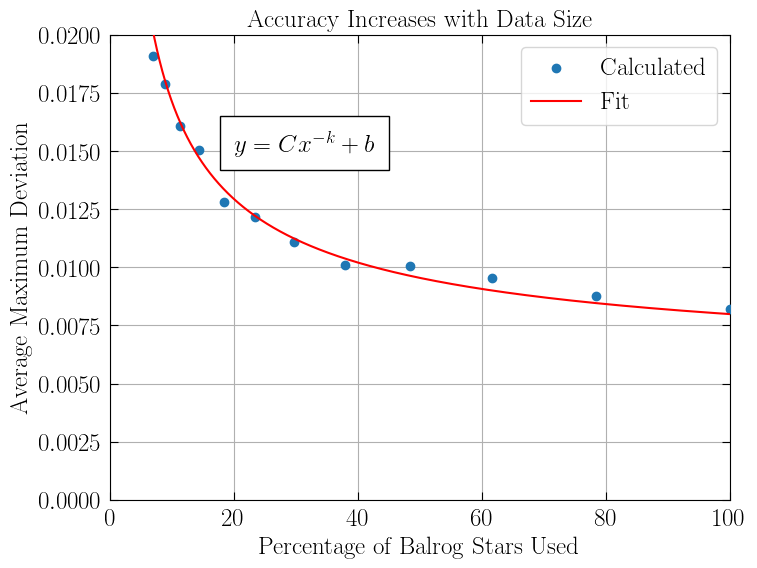

In [21]:
plt.figure()
plt.scatter(persToUse, aveMaxDev, zorder = 3, label = 'Calculated')
plt.plot(np.linspace(0.01, 100, 10000), func(np.linspace(0.01, 100, 10000), *popt), color = 'r', zorder = 3, label = 'Fit')
plt.text(20, 0.015, r'$y = Cx^{-k} + b$',
        
        bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}, zorder = 3)
plt.legend()
plt.ylim([0, 0.02])
plt.xlim([0, 100])
plt.grid(zorder = 0)
plt.ylabel('Average Maximum Deviation')
plt.xlabel('Percentage of Balrog Stars Used')
plt.title('Accuracy Increases with Data Size')
plt.show()

In [3]:
allPixFile = balrConfig.test1aAllPixFile
galaFile = balrConfig.test1aGalaFile
validPixFile = balrConfig.test1ValidPixFile

In [4]:
PCA_Store_File = balrConfig.test1aDir + 'PCA_Maps.fits'

In [5]:
injData = fitsio.read(allPixFile)

In [6]:
injPix = hp.ang2pix(res, injData['RA'], injData['DEC'], nest = True, lonlat = True)
origValidPix = np.unique(injPix)

In [7]:
detData = fitsio.read(galaFile)

In [8]:
detPix = hp.ang2pix(res, detData['RA'], detData['DEC'], nest = True, lonlat = True)

In [9]:
injPix = np.sort(injPix)

detPix = np.sort(detPix)

In [10]:
injPixUnique, injPixCounts = np.unique(injPix, return_counts = True)

_, detPixCounts = np.unique(np.append(detPix, origValidPix), return_counts = True)
detPixCounts = detPixCounts - 1

In [11]:
injPixCounts

array([1, 5, 2, ..., 2, 1, 2])

In [12]:
detPixCounts

array([0, 2, 1, ..., 1, 0, 1])

In [13]:
matchInds = np.zeros(len(detPix), dtype = int)

In [14]:
startInjInds = np.append(np.array([0]), np.cumsum(injPixCounts)[:-1])

In [15]:
startDetInds = np.append(np.array([0]), np.cumsum(detPixCounts)[:-1])

In [16]:
for i in np.arange(len(detPixCounts)):
    if detPixCounts[i] == 0:
        continue
    matchInds[startDetInds[i]: startDetInds[i] + detPixCounts[i]] = np.arange(detPixCounts[i]).astype(int) + startInjInds[i]

In [17]:
includeInds = np.full(len(injPix), False, dtype = bool)
includeInds[0:int(perObjectsToUse*len(includeInds))] = True
np.random.shuffle(includeInds)

In [18]:
detPix = detPix[includeInds[matchInds]]
injPix = injPix[includeInds]

validPix =  np.unique(injPix)

In [19]:
pcCrop = np.isin(origValidPix, validPix)

In [20]:
_, origDetPixCounts = np.unique(np.append(validPix, detPix), return_counts = True)
origDetPixCounts = origDetPixCounts - 1

In [21]:
condFiles = balrConfig.test1aCondFiles

pcMaps = []

# This loops over every condition file
for condFile in condFiles:
    condData = fitsio.read(condFile) # This reads in the data
    pcMaps.append(condData['SIGNAL'][pcCrop]) # Only stores the values that are in pixels with injections

pcMaps = np.array(pcMaps) # Converts to an array

# PC_Maps = fitsio.read(PCA_Store_File)
# pcMaps = []
# for i in np.arange(50):
#     pcMaps.append(PC_Maps[str(i)])
# pcMaps = np.array(pcMaps)

## Make sure to normalize to this aveDet after each step just in case.

In [22]:
aveDet = np.sum(origDetPixCounts) / len(origDetPixCounts)

In [23]:
# sortInds = []
# for i in range(len(pcMaps)):
#     sortInds.append(pcMaps[i].argsort())
# sortInds = np.array(sortInds)

# 80% Test
trainInds = np.full(len(pcMaps[0]), False, dtype = bool)
trainInds[0:int(0.8*len(trainInds))] = True
np.random.shuffle(trainInds)

sortInds = []
for i in range(len(pcMaps)):
    sortInds.append(pcMaps[i][trainInds].argsort())
sortInds = np.array(sortInds)

In [24]:
binIndLims = [0]

for j in range(binNum):
    binIndLims.append(int((np.sum(trainInds) - binIndLims[-1]) / (binNum - j)) + (binIndLims[-1]))
    # binIndLims.append(int((len(pcMaps[0]) - binIndLims[-1]) / (binNum - j)) + (binIndLims[-1]))

In [25]:
xBins = []

for i in range(len(pcMaps)):
    PC_Map_Sort = pcMaps[i][trainInds][sortInds[i][::1]]
    pcBins = []
    for j in range(binNum):
        pcBins.append(PC_Map_Sort[binIndLims[j]:binIndLims[j+1]])
    indXBin = []

    for j in range(binNum):
        indXBin.append(np.sum(pcBins[j]) / len(pcBins[j]))
        
    xBins.append(np.array(indXBin))

xBins = np.array(xBins)

In [26]:
yBinsOrig = []
for i in range(len(pcMaps)):
    detSort = origDetPixCounts[trainInds][sortInds[i][::1]]
    detBins = []
    for j in range(binNum):
        detBins.append(detSort[binIndLims[j]:binIndLims[j+1]])
    indYBinOrig = []

    for j in range(binNum):
        indYBinOrig.append(np.sum(detBins[j]) / (aveDet * len(detBins[j])))

    yBinsOrig.append(np.array(indYBinOrig))

yBinsOrig = np.array(yBinsOrig)

In [28]:
detPixCounts = np.copy(origDetPixCounts)

In [29]:
timeThrough = 0
allErrors = []

start = timer()

while(True):
    
    timeThrough += 1
    if timeThrough % 20 == 0:
        print(timeThrough)
    
    yBins = []
    for i in range(len(pcMaps)):
        detSort = detPixCounts[trainInds][sortInds[i][::1]]
        detBins = []
        for j in range(binNum):
            detBins.append(detSort[binIndLims[j]:binIndLims[j+1]])
        indYBin = []

        for j in range(binNum):
            indYBin.append(np.sum(detBins[j]) / (aveDet * len(detBins[j])))

        yBins.append(np.array(indYBin))

    yBins = np.array(yBins)
    
    index, maxErr = mostSigInd(yBins)
    if index == -1:
        break
        
    allErrors.append(maxErr)
        
    corrFunc = inter.interp1d(xBins[index], yBins[index], bounds_error = False, fill_value = (yBins[index][0], yBins[index][-1]))
    
    detPixCounts = detPixCounts / (corrFunc(pcMaps[index]))
    
    detPixCounts = detPixCounts * aveDet / (np.sum(detPixCounts) / len(detPixCounts))
    
    if timeThrough == 1:
        end = timer()
        print(str(end - start) + ' seconds per loop') # time in seconds

3.106606442015618 seconds per loop
20
40
60
80
100


In [30]:
errorsFile = balrConfig.test1Dir + str(perObjectsToUse) + '_Errors_' + str(cutOffPercent) + '.fits'
detPixFile = balrConfig.test1Dir + str(perObjectsToUse) + '_Pix_Counts_' + str(cutOffPercent) + '.fits'
trainIndsFile = balrConfig.test1Dir + str(perObjectsToUse) + '_Train_Inds_' + str(cutOffPercent) + '.fits'

In [31]:
my_table = Table()
my_table['Errors'] = allErrors
my_table.write(errorsFile, overwrite = True)

In [32]:
my_table = Table()
my_table['Counts'] = detPixCounts
my_table.write(detPixFile, overwrite = True)

In [33]:
my_table = Table()
my_table['Inds'] = trainInds
my_table.write(trainIndsFile, overwrite = True)

In [34]:
allErrors = fitsio.read(errorsFile)['Errors']
detPixCounts = fitsio.read(detPixFile)['Counts']
trainInds = fitsio.read(trainIndsFile)['Inds']

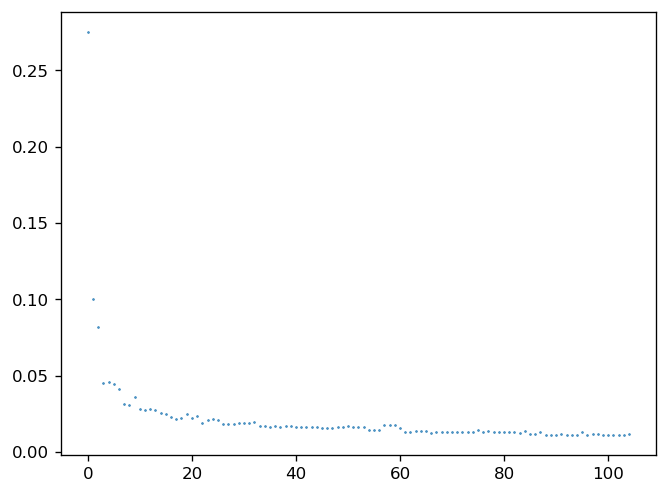

In [35]:
plt.figure(dpi = 120)
plt.scatter(np.arange(len(allErrors)), allErrors, s = 0.25)
plt.show()

In [36]:
condFiles = balrConfig.test1aCondFiles
conditions = Config.conditions

In [37]:
condMaps = np.copy(pcMaps)

# # This loops over every condition file
# for condFile in condFiles:
#     condData = fitsio.read(condFile) # This reads in the data
#     condMaps.append(condData['SIGNAL']) # Only stores the values that are in pixels with injections

# condMaps = np.array(condMaps, dtype = object) # Converts to an array

## 1D Cases

In [38]:
binIndLims = [0]

for j in range(binNum):
    binIndLims.append(int((np.sum(~trainInds) - binIndLims[-1]) / (binNum - j)) + (binIndLims[-1]))
    # binIndLims.append(int((len(pcMaps[0]) - binIndLims[-1]) / (binNum - j)) + (binIndLims[-1]))

In [39]:
condMaxErrors = []

for condInd in range(len(condMaps)):
    condMap = condMaps[condInd]
    condSortInds = condMap[~trainInds].argsort()
    
    condSort = condMap[~trainInds][condSortInds[::1]]
    detStarTemp = detPixCounts[~trainInds][condSortInds[::1]]
    origDetStarTemp = origDetPixCounts[~trainInds][condSortInds[::1]]

    origDetBins = []
    detBins = []
    condBins = []

    for j in range(10):
        origDetBins.append(origDetStarTemp[binIndLims[j]:binIndLims[j+1]])
        detBins.append(detStarTemp[binIndLims[j]:binIndLims[j+1]])
        condBins.append(condSort[binIndLims[j]:binIndLims[j+1]])

    yBinCondOrig = []
    yBinCond = []
    xBinCond = []

    for j in range(10):
        yBinCondOrig.append(np.sum(origDetBins[j]) / (aveDet * len(origDetBins[j])))
        yBinCond.append(np.sum(detBins[j]) / (aveDet * len(detBins[j])))
        xBinCond.append(np.sum(condBins[j]) / len(condBins[j]))

    xBinCond = np.array(xBinCond)
    yBinCond = np.array(yBinCond)
    yBinCondOrig = np.array(yBinCondOrig)
    
    condMaxErrors.append(np.max(np.abs(yBinCond - 1)))
    
    # plt.figure(dpi = 120)
    # plt.plot(xBinCond, yBinCond, marker = 'o', label = r'Corrected Dependency, ' + r'$\sigma = $' + str(np.round(np.std(yBinCond), decimals = 3)), zorder = 4)
    # plt.plot(xBinCond, yBinCondOrig, marker = 'o', label = r'Original Dependency, ' + r'$\sigma = $' + str(np.round(np.std(yBinCondOrig), decimals = 3)), zorder = 4)
    # plt.axhline(y = 1, color = 'black', linestyle = '--', zorder = 3)
    # plt.legend()
    # plt.title('Stellar Detection Rate Dependencies')
    # plt.grid(zorder = 0)
    # plt.xlabel(conditions[condInd])
    # plt.ylabel(r'$N/\langle N\rangle$')
    # plt.savefig('80PerTrainStarsBetter/' + conditions[condInd])

In [40]:
condErrorsFile = balrConfig.test1Dir + 'PartialInclusion/' + str(perObjectsToUse) + '_Cond_Errors_' + str(cutOffPercent) + '.fits'
my_table = Table()
my_table['Errors'] = condMaxErrors
my_table.write(condErrorsFile, overwrite = True)

## 2D Cases

In [41]:
# index_one = 37
# index_two = 75

In [42]:
# condSortInds = condMaps[index_one][~trainInds].argsort()
# sortedFirst = condMaps[index_one][~trainInds][condSortInds[::1]]
# first_bin_lims = []
# for i in range(binNum):
#     first_bin_lims.append(sortedFirst[binIndLims[i]])
# first_bin_lims.append(sortedFirst[-1])

# condSortInds = condMaps[index_two][~trainInds].argsort()
# sortedSecond = condMaps[index_two][~trainInds][condSortInds[::1]]
# second_bin_lims = []
# for i in range(binNum):
#     second_bin_lims.append(sortedSecond[binIndLims[i]])
# second_bin_lims.append(sortedSecond[-1])

# # sortedFirst = condMaps[index_one][sortInds[index_one][::1]]
# # first_bin_lims = []
# # for i in range(binNum):
# #     first_bin_lims.append(sortedFirst[binIndLims[i]])
# # first_bin_lims.append(sortedFirst[-1])

# # sortedSecond = condMaps[index_two][sortInds[index_two][::1]]
# # second_bin_lims = []
# # for i in range(binNum):
# #     second_bin_lims.append(sortedSecond[binIndLims[i]])
# # second_bin_lims.append(sortedSecond[-1])

In [43]:
# plt.figure(dpi = 120)
# bins = plt.hist2d(condMaps[index_one][~trainInds], condMaps[index_two][~trainInds], bins = (first_bin_lims, second_bin_lims))
# countBins = bins[0]
# plt.xlabel(conditions[index_one])
# plt.ylabel(conditions[index_two])
# plt.title('Distribution of Pixels with Survey Property')
# plt.colorbar()
# plt.show()

In [44]:
# normWeights = np.ones_like(condMaps[index_one][~trainInds])
# for i in np.arange(len(first_bin_lims) - 1):
#     for j in np.arange(len(second_bin_lims) - 1):
#         inds = np.where((condMaps[index_one][~trainInds] <= first_bin_lims[i + 1]) & (condMaps[index_one][~trainInds] >= first_bin_lims[i]) & (condMaps[index_two][~trainInds] <= second_bin_lims[j + 1]) & (condMaps[index_two][~trainInds] >= second_bin_lims[j]))[0]
#         if countBins[i][j] != 0:
#             normWeights[inds] = 1 / (countBins[i][j])

In [45]:
# xHist = np.linspace(0, 100, 10)
# yHist = np.linspace(0, 100, 10)
# mesh = np.meshgrid(xHist, yHist)
# xHist = mesh[0].flatten()
# yHist = mesh[1].flatten()
# pixCountBins = (countBins.T).flatten()

# plt.figure(dpi = 120)
# origCountBins = plt.hist2d(xHist, yHist, weights = pixCountBins)
# origCountBins = origCountBins[0].flatten()
# plt.xlabel(conditions[index_one] + ' Percentile')
# plt.ylabel(conditions[index_two] + ' Percentile')
# plt.title('Distribution of Pixels with Survey Property')
# plt.colorbar()
# plt.show()

In [46]:
# plt.figure(dpi = 120)
# countBins = plt.hist2d(condMaps[index_one][~trainInds], condMaps[index_two][~trainInds], bins = (first_bin_lims, second_bin_lims), weights = origDetPixCounts[~trainInds] * normWeights / aveDet)
# countBins = countBins[0]
# plt.xlabel(conditions[index_one])
# plt.ylabel(conditions[index_two])
# plt.title('Distribution of Detection Rates with Survey Property')
# plt.colorbar()
# plt.show()

In [47]:
# xHist = np.linspace(0, 100, 10)
# yHist = np.linspace(0, 100, 10)
# mesh = np.meshgrid(xHist, yHist)
# xHist = mesh[0].flatten()
# yHist = mesh[1].flatten()
# countBins = (countBins.T).flatten()

# plt.figure(dpi = 120)
# origCountBins = plt.hist2d(xHist, yHist, weights = countBins)
# origCountBins = (origCountBins[0].T).flatten()
# plt.xlabel(conditions[index_one] + ' Percentile')
# plt.ylabel(conditions[index_two] + ' Percentile')
# plt.title('Distribution of Detection Rates with Survey Property')
# plt.colorbar()
# plt.show()

In [48]:
# plt.figure(dpi = 120)
# countBins = plt.hist2d(condMaps[index_one][~trainInds], condMaps[index_two][~trainInds], bins = (first_bin_lims, second_bin_lims), weights = detPixCounts[~trainInds] * normWeights / aveDet)
# countBins = countBins[0]
# plt.xlabel(conditions[index_one])
# plt.ylabel(conditions[index_two])
# plt.title('Corrected Distribution of Detection Rates with Survey Property')
# plt.colorbar()
# plt.show()

In [49]:
# xHist = np.linspace(0, 100, 10)
# yHist = np.linspace(0, 100, 10)
# mesh = np.meshgrid(xHist, yHist)
# xHist = mesh[0].flatten()
# yHist = mesh[1].flatten()
# countBins = (countBins.T).flatten()

# plt.figure(dpi = 120)
# corrCountBins = plt.hist2d(xHist, yHist, weights = countBins)
# corrCountBins = (corrCountBins[0].T).flatten()
# plt.xlabel(conditions[index_one] + ' Percentile')
# plt.ylabel(conditions[index_two] + ' Percentile')
# plt.title('Corrected Distribution of Detection Rates with Survey Property')
# plt.colorbar()
# plt.show()

## Metrics to Gauge Success:

Want to look at variations from one while also considering the fact that we don't really care about regions with hardly any pixels. My current plan is to do a (1 - bin) squared for the above plot as well as the pre correction plot, weight each one by the number of pixels in that bin from the initial plots, and then finally divide out by the total count of pixels.

In [50]:
# 1 - (np.sum(pixCountBins * ((corrCountBins - 1)**2)) / np.sum(pixCountBins * ((origCountBins - 1)**2)))

In [51]:
# np.sum(pixCountBins * ((origCountBins - 1)**2)) / np.sum(pixCountBins)

## Random Tests Done First

In [52]:
# metricFile = balrConfig.test1aDir + '2D_Metrics_' + str(cutOffPercent) + '.fits'

In [53]:
# ind_ones = np.arange(92)
# ind_twos = np.arange(92)
# mesh = np.meshgrid(ind_ones, ind_twos)
# ind_ones = mesh[0].flatten()
# ind_twos = mesh[1].flatten()
# cutInds = np.where(ind_ones < ind_twos)[0]
# allIndOnes = ind_ones[cutInds]
# allIndTwos = ind_twos[cutInds]

# # allMetrics = 2.0 * np.ones_like(allIndOnes)
# # allMetricWeights = -1.0 * np.ones_like(allIndOnes)

# metricData = fitsio.read(metricFile)
# allMetrics = metricData['Metric']
# allMetricWeights = metricData['Weight']

In [54]:
# for ind in np.arange(len(allIndOnes)):
#     index_one = allIndOnes[ind]
#     index_two = allIndTwos[ind]
    
#     if allMetrics[ind] < 1.5:
#         if allMetricWeights[ind] > -0.5:
#             continue
        
#     condSortInds = condMaps[index_one][~trainInds].argsort()
#     sortedFirst = condMaps[index_one][~trainInds][condSortInds[::1]]
#     first_bin_lims = []
#     for i in range(binNum):
#         first_bin_lims.append(sortedFirst[binIndLims[i]])
#     first_bin_lims.append(sortedFirst[-1])

#     condSortInds = condMaps[index_two][~trainInds].argsort()
#     sortedSecond = condMaps[index_two][~trainInds][condSortInds[::1]]
#     second_bin_lims = []
#     for i in range(binNum):
#         second_bin_lims.append(sortedSecond[binIndLims[i]])
#     second_bin_lims.append(sortedSecond[-1])
    
#     plt.figure(dpi = 20)
#     bins = plt.hist2d(condMaps[index_one][~trainInds], condMaps[index_two][~trainInds], bins = (first_bin_lims, second_bin_lims))
#     countBins = bins[0]
#     plt.xlabel(conditions[index_one])
#     plt.ylabel(conditions[index_two])
#     plt.title('Distribution of Pixels with Survey Property')
#     plt.colorbar()
#     plt.show()
    
#     normWeights = np.ones_like(condMaps[index_one][~trainInds])
#     for i in np.arange(len(first_bin_lims) - 1):
#         for j in np.arange(len(second_bin_lims) - 1):
#             inds = np.where((condMaps[index_one][~trainInds] <= first_bin_lims[i + 1]) & (condMaps[index_one][~trainInds] >= first_bin_lims[i]) & (condMaps[index_two][~trainInds] <= second_bin_lims[j + 1]) & (condMaps[index_two][~trainInds] >= second_bin_lims[j]))[0]
#             if countBins[i][j] != 0:
#                 normWeights[inds] = 1 / (countBins[i][j])
                
#     xHist = np.linspace(0, 100, 10)
#     yHist = np.linspace(0, 100, 10)
#     mesh = np.meshgrid(xHist, yHist)
#     xHist = mesh[0].flatten()
#     yHist = mesh[1].flatten()
#     pixCountBins = (countBins.T).flatten()

#     plt.figure(dpi = 20)
#     origCountBins = plt.hist2d(xHist, yHist, weights = pixCountBins)
#     origCountBins = origCountBins[0].flatten()
#     plt.xlabel(conditions[index_one] + ' Percentile')
#     plt.ylabel(conditions[index_two] + ' Percentile')
#     plt.title('Distribution of Pixels with Survey Property')
#     plt.colorbar()
#     plt.show()
    
#     plt.figure(dpi = 20)
#     countBins = plt.hist2d(condMaps[index_one][~trainInds], condMaps[index_two][~trainInds], bins = (first_bin_lims, second_bin_lims), weights = origDetPixCounts[~trainInds] * normWeights / aveDet)
#     countBins = countBins[0]
#     plt.xlabel(conditions[index_one])
#     plt.ylabel(conditions[index_two])
#     plt.title('Distribution of Detection Rates with Survey Property')
#     plt.colorbar()
#     plt.show()
    
#     xHist = np.linspace(0, 100, 10)
#     yHist = np.linspace(0, 100, 10)
#     mesh = np.meshgrid(xHist, yHist)
#     xHist = mesh[0].flatten()
#     yHist = mesh[1].flatten()
#     countBins = (countBins.T).flatten()

#     plt.figure(dpi = 20)
#     origCountBins = plt.hist2d(xHist, yHist, weights = countBins)
#     origCountBins = (origCountBins[0].T).flatten()
#     plt.xlabel(conditions[index_one] + ' Percentile')
#     plt.ylabel(conditions[index_two] + ' Percentile')
#     plt.title('Distribution of Detection Rates with Survey Property')
#     plt.colorbar()
#     plt.show()
    
#     plt.figure(dpi = 20)
#     countBins = plt.hist2d(condMaps[index_one][~trainInds], condMaps[index_two][~trainInds], bins = (first_bin_lims, second_bin_lims), weights = detPixCounts[~trainInds] * normWeights / aveDet)
#     countBins = countBins[0]
#     plt.xlabel(conditions[index_one])
#     plt.ylabel(conditions[index_two])
#     plt.title('Corrected Distribution of Detection Rates with Survey Property')
#     plt.colorbar()
#     plt.show()
    
#     xHist = np.linspace(0, 100, 10)
#     yHist = np.linspace(0, 100, 10)
#     mesh = np.meshgrid(xHist, yHist)
#     xHist = mesh[0].flatten()
#     yHist = mesh[1].flatten()
#     countBins = (countBins.T).flatten()

#     plt.figure(dpi = 20)
#     corrCountBins = plt.hist2d(xHist, yHist, weights = countBins)
#     corrCountBins = (corrCountBins[0].T).flatten()
#     plt.xlabel(conditions[index_one] + ' Percentile')
#     plt.ylabel(conditions[index_two] + ' Percentile')
#     plt.title('Corrected Distribution of Detection Rates with Survey Property')
#     plt.colorbar()
#     plt.show()
    
#     metric = 1 - (np.sum(pixCountBins * ((corrCountBins - 1)**2)) / np.sum(pixCountBins * ((origCountBins - 1)**2)))
    
#     allMetrics[ind] = metric
#     allMetricWeights[ind] = np.sum(pixCountBins * ((origCountBins - 1)**2)) / np.sum(pixCountBins)
    
#     my_table = Table()
#     my_table['Metric'] = allMetrics
#     my_table['Weight'] = allMetricWeights
#     my_table.write(metricFile, overwrite = True)

In [55]:
# plt.figure(dpi = 120)
# plt.hist(allMetrics[np.where(allMetrics < 1.5)[0]], bins = np.linspace(0.6, 1, 101), weights = allMetricWeights[np.where(allMetrics < 1.5)[0]], zorder = 3, density = True)
# plt.xlabel('Metric Improvement Value')
# plt.ylabel('Weighted Distribution')
# plt.title('Galaxy Detection 2D Relation Improvements')
# plt.grid(zorder = 0)
# plt.show()

In [56]:
# my_table = Table()
# my_table['Metric'] = allMetrics
# my_table['Weight'] = allMetricWeights
# my_table.write(metricFile, overwrite = True)

In [57]:
# len(np.where(allMetrics<1.5)[0])

In [58]:
# np.min(allMetrics[np.where(allMetrics<1.5)[0]])